In [1]:
!pip install evaluate albumentations pillow matplotlib transformers datasets

In [2]:
import json
import torch
import datasets
import requests
import evaluate
import numpy as np
import huggingface_hub
from PIL import Image
import albumentations as A
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from typing import Tuple, Any
from dataclasses import dataclass
from datasets import load_dataset
import matplotlib.patches as mpatches
from huggingface_hub import hf_hub_download
from torch.utils.data import Dataset, DataLoader
from transformers import (
    MaskFormerImageProcessor,
    AutoImageProcessor,
    MaskFormerForInstanceSegmentation,
)

torch.manual_seed(42)

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
!pip install python-dotenv

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [4]:
from dotenv import load_dotenv
import os

In [5]:
load_dotenv()

False

In [7]:
hf_dataset_id = "itsskofficial/sih-dataset-multiclass"
dataset = load_dataset(hf_dataset_id)

dataset = dataset.shuffle(seed=1)
dataset = dataset["train"].train_test_split(test_size=0.2)
train_ds, test_ds = dataset["train"], dataset["test"]

dataset = train_ds.train_test_split(test_size=0.05)
train_ds, val_ds = dataset["train"], dataset["test"]

Resolving data files:   0%|          | 0/68 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/68 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/51 [00:00<?, ?it/s]

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 76
    })
    test: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 4
    })
})

In [ ]:
filename = "id2label.json"
id2label = json.load(
    open(hf_hub_download(hf_dataset_id, filename, repo_type="dataset"), "r")
)
id2label = {int(k): v for k, v in id2label.items()}
print(id2label)

In [9]:
id2label = {
    1: "roads",          # Roads (Red)
    2: "waterbodies",    # Water Bodies (Blue)
    3: "rcc_rooftop",    # RCC Rooftop (Green)
    4: "tin_rooftop",    # Tin Rooftop (Yellow)
    5: "tiled_rooftop",  # Tiled Rooftop (Magenta)
    6: "other_rooftops"  # Other Rooftops (Brown)
}

In [ ]:
example = train_ds[0]
print(example)
segmentation_map = np.array(example["label"])
image_array = np.array(example["pixel_values"])
print(
    f"Shape : Image: {image_array.shape} - Segmentation map: {segmentation_map.shape}"
)

print(segmentation_map)

In [ ]:
def show_samples(dataset: datasets.Dataset, n: int = 5):
    """
    Displays 'n' samples from the dataset.
    ----
    Args:
      - dataset: The dataset which should contain 'pixel_values' and 'label' in its items.
      - n (int): Number of samples to display.

    """
    if n > len(dataset):
        raise ValueError("n is larger than the dataset size")

    fig, axs = plt.subplots(n, 2, figsize=(10, 5 * n))

    for i in range(n):
        sample = dataset[i]
        image, label = np.array(sample["pixel_values"]), sample["label"]

        axs[i, 0].imshow(image)
        axs[i, 0].set_title("Image")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(image)
        axs[i, 1].imshow(label, cmap="nipy_spectral", alpha=0.5)
        axs[i, 1].set_title("Segmentation Map")
        axs[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
show_samples(train_ds, n=4)

In [10]:
preprocessor = MaskFormerImageProcessor(
    ignore_index=0,
    do_reduce_labels=False,
    do_resize=False,
    do_rescale=False,
    do_normalize=False,
)
ade_mean = [123.675 / 255, 116.280 / 255, 103.530 / 255]
ade_std = [58.395 / 255, 57.120 / 255, 57.375 / 255]

In [11]:
train_transform = A.Compose(
    [
        A.RandomCrop(width=512, height=512),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=ade_mean, std=ade_std),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(width=512, height=512),
        A.Normalize(mean=ade_mean, std=ade_std),
    ]
)

In [12]:
@dataclass
class SegmentationDataInput:
    original_image: np.ndarray
    transformed_image: np.ndarray
    original_segmentation_map: np.ndarray
    transformed_segmentation_map: np.ndarray


class SemanticSegmentationDataset(Dataset):
    def __init__(self, dataset: Dataset, transform: Any) -> None:
        """
        Dataset for Semantic Segmentation.
        ----
        Args:
          - dataset: A dataset containing images and segmentation maps.
          - transform: A transformation function to apply to the images and segmentation maps.
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int) -> SegmentationDataInput:
        sample = self.dataset[idx]

        original_image = np.array(sample["pixel_values"])
        if original_image.shape[-1] > 3:
            original_image = original_image[:, :, :3]  # Keep only the first 3 dimensions

        original_segmentation_map = np.array(sample["label"])

        transformed = self.transform(
            image=original_image, mask=original_segmentation_map
        )
        transformed_image = transformed["image"].transpose(
            2, 0, 1
        )  
        transformed_segmentation_map = transformed["mask"]

        return SegmentationDataInput(
            original_image=original_image,
            transformed_image=transformed_image,
            original_segmentation_map=original_segmentation_map,
            transformed_segmentation_map=transformed_segmentation_map,
        )

In [13]:
def collate_fn(batch: SegmentationDataInput) -> dict:
    original_images = [sample.original_image for sample in batch]
    transformed_images = [sample.transformed_image for sample in batch]
    original_segmentation_maps = [sample.original_segmentation_map for sample in batch]
    transformed_segmentation_maps = [
        sample.transformed_segmentation_map for sample in batch
    ]

    preprocessed_batch = preprocessor(
        transformed_images,
        segmentation_maps=transformed_segmentation_maps,
        return_tensors="pt",
    )

    preprocessed_batch["original_images"] = original_images
    preprocessed_batch["original_segmentation_maps"] = original_segmentation_maps

    return preprocessed_batch

In [14]:
train_dataset = SemanticSegmentationDataset(train_ds, transform=train_transform)
val_dataset = SemanticSegmentationDataset(val_ds, transform=train_transform)
test_dataset = SemanticSegmentationDataset(test_ds, transform=test_transform)

train_dataloader = DataLoader(
    train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn
)
val_dataloader = DataLoader(
    val_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn
)
test_dataloader = DataLoader(
    test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn
)

In [15]:
sample = next(iter(train_dataloader))
print(
    {
        key: value[0].shape if isinstance(value, list) else value.shape
        for key, value in sample.items()
    }
)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f50de83be50>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f50de83be50>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f50de83be50>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_t

{'pixel_values': torch.Size([2, 3, 512, 512]), 'pixel_mask': torch.Size([2, 512, 512]), 'mask_labels': torch.Size([0, 512, 512]), 'class_labels': torch.Size([0]), 'original_images': (3000, 3000, 3), 'original_segmentation_maps': (3000, 3000)}


In [ ]:
def denormalize_image(image, mean, std):
    """
    Denormalizes a normalized image.
    ----
    Args:
     - image (numpy.ndarray): The normalized image.
     - mean (list or numpy.ndarray): The mean used for normalization.
     - std (list or numpy.ndarray): The standard deviation used for normalization.

    """
    unnormalized_image = (image * std[:, None, None]) + mean[:, None, None]
    unnormalized_image = (unnormalized_image * 255).numpy().astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    return unnormalized_image

In [ ]:
denormalized_image = denormalize_image(sample["pixel_values"][0], ade_mean, ade_std)
pil_image = Image.fromarray(denormalized_image)
pil_image

In [ ]:
labels = [id2label[label] for label in sample["class_labels"][0].tolist()]
print(labels)

In [ ]:
def visualize_mask(sample, labels, label_name):
    print(f"Category: {label_name}")
    idx = labels.index(label_name)

    visual_mask = (sample["mask_labels"][0][idx].bool().numpy() * 255).astype(np.uint8)
    return Image.fromarray(visual_mask)

In [ ]:
visualize_mask(sample, labels, labels[0])

In [18]:
processor = AutoImageProcessor.from_pretrained("facebook/maskformer-swin-base-ade")
model = MaskFormerForInstanceSegmentation.from_pretrained(
    "facebook/maskformer-swin-base-ade", id2label=id2label, ignore_mismatched_sizes=True,
)

/opt/conda/lib/python3.10/site-packages/transformers/utils/deprecation.py:165: FutureWarning: `max_size` is deprecated and removed starting from version 4.27.0 for `MaskFormerImageProcessor.__init__`.
  return func(*args, **kwargs)
Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([7]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
sample = next(iter(train_dataloader))
outputs = model(
    pixel_values=sample["pixel_values"],
    pixel_mask=sample["pixel_mask"],
    class_labels=sample["class_labels"],
    mask_labels=sample["mask_labels"],
)
print(outputs.loss)

In [20]:
for param in model.model.pixel_level_module.parameters():
    param.requires_grad = False

for name, param in model.model.pixel_level_module.named_parameters():
    assert not param.requires_grad

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
metric = evaluate.load("mean_iou")


def evaluate_model(
    model: MaskFormerForInstanceSegmentation,
    dataloader: DataLoader,
    preprocessor: AutoImageProcessor,
    metric: Any,
    id2label: dict,
    max_batches=None,
):
    model.eval()
    running_iou = 0
    num_batches = 0

    with torch.no_grad():
        for idx, batch in enumerate(tqdm(dataloader)):
            if max_batches and idx >= max_batches:
                break

            pixel_values = batch["pixel_values"].to(device)
            outputs = model(pixel_values=pixel_values)

            original_images = batch["original_images"]
            target_sizes = [
                (image.shape[0], image.shape[1]) for image in original_images
            ]

            # Post-process predictions
            predicted_segmentation_maps = (
                preprocessor.post_process_semantic_segmentation(
                    outputs, target_sizes=target_sizes
                )
            )

            ground_truth_segmentation_maps = [
                torch.tensor(gt, device=pixel_values.device) for gt in batch["original_segmentation_maps"]
            ]

            resized_predicted_maps = [
                torch.nn.functional.interpolate(
                    pred.unsqueeze(0).unsqueeze(0),
                    size=gt.shape,
                    mode="nearest",
                ).squeeze().to(torch.long)
                for pred, gt in zip(predicted_segmentation_maps, ground_truth_segmentation_maps)
            ]

            predictions = [pred.cpu().numpy() for pred in resized_predicted_maps]
            references = [gt.cpu().numpy() for gt in ground_truth_segmentation_maps]

            metric.add_batch(
                references=references,
                predictions=predictions,
            )

            running_iou += metric.compute(num_labels=len(id2label), ignore_index=0)["mean_iou"]
            num_batches += 1

    mean_iou = running_iou / num_batches
    return mean_iou


def train_model(
    model: MaskFormerForInstanceSegmentation,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    preprocessor: AutoImageProcessor,
    metric: AutoImageProcessor,
    id2label: dict,
    num_epochs=100,
    learning_rate=5e-5,
    log_interval=100,
):
    """
    Trains the MaskFormer model for semantic segmentation over a specified number of epochs and evaluates it on a validation set.
    ----
    Args:
      - model (MaskFormerForInstanceSegmentation): The model to be trained.
      - train_dataloader (DataLoader): DataLoader for the training data.
      - val_dataloader (DataLoader): DataLoader for the validation data.
      - preprocessor (AutoImageProcessor): The preprocessor used for preparing the data.
      - metric (Any): Metric instance used for calculating performance metrics.
      - id2label (dict): Dictionary mapping class IDs to their corresponding labels.
      - num_epochs (int): Number of epochs to train the model.
      - learning_rate (float): Learning rate for the optimizer.
      - log_interval (int): Interval (in number of batches) at which to log training progress.

    """
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        print(f"Current epoch: {epoch+1}/{num_epochs}")
        model.train()

        running_loss = 0.0
        num_samples = 0

        for idx, batch in enumerate(tqdm(train_dataloader)):
            optimizer.zero_grad()

            outputs = model(
                pixel_values=batch["pixel_values"].to(device),
                mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                class_labels=[labels.to(device) for labels in batch["class_labels"]],
            )

            loss = outputs.loss
            loss.backward()

            batch_size = batch["pixel_values"].size(0)
            running_loss += loss.item()
            num_samples += batch_size

            if idx % log_interval == 0 and idx > 0:
                print(f"Iteration {idx} - loss: {running_loss/num_samples}")

            optimizer.step()
        val_mean_iou = evaluate_model(
            model, val_dataloader, preprocessor, metric, id2label, max_batches=6
        )
        print(f"Validation Mean IoU: {val_mean_iou}")

In [22]:
train_model(
    model,
    train_dataloader,
    val_dataloader,
    preprocessor,
    metric,
    id2label,
    num_epochs=1,
    log_interval=1,
)

Current epoch: 1/1


  0%|          | 0/38 [00:00<?, ?it/s]

Iteration 1 - loss: 1.4426955580711365
Iteration 2 - loss: 1.5206258694330852
Iteration 3 - loss: 1.596000075340271
Iteration 4 - loss: 1.5488088607788086
Iteration 5 - loss: 1.5608656803766887
Iteration 6 - loss: 1.5040349619729179
Iteration 7 - loss: 1.465286135673523
Iteration 8 - loss: 1.3502634432580736
Iteration 9 - loss: 1.3370275437831878
Iteration 10 - loss: 1.2459314330057665
Iteration 11 - loss: 1.1613182413081329
Iteration 12 - loss: 1.159695138151829
Iteration 13 - loss: 1.1563728951982088
Iteration 14 - loss: 1.0923137287298839
Iteration 15 - loss: 1.1054120305925608
Iteration 16 - loss: 1.1075741350650787
Iteration 17 - loss: 1.110325093070666
Iteration 18 - loss: 1.0595367895929437
Iteration 19 - loss: 1.0422454953193665
Iteration 20 - loss: 1.0467574709937686
Iteration 21 - loss: 1.0058319771831685
Iteration 22 - loss: 0.9654218790971715
Iteration 23 - loss: 0.9779416027789315
Iteration 24 - loss: 0.9678364279866218
Iteration 25 - loss: 0.9354990987250438
Iteration 26 

  0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Validation Mean IoU: 0.32419676614240184


In [ ]:
test_mean_iou = evaluate_model(model, test_dataloader, preprocessor, metric, id2label)
print(f"Test Mean IoU: {test_mean_iou}")

In [25]:
def show_inference_samples(
    model: MaskFormerForInstanceSegmentation,
    dataloader: DataLoader,
    preprocessor: AutoImageProcessor,
    n: int = 5,
):
    """
    Displays 'n' samples from the dataloader with model inference results.
    ----
    Args:
     - model: The trained model.
     - dataloader: DataLoader containing the dataset for inference.
     - preprocessor: The preprocessor used for post-processing the outputs.
     - n (int): Number of samples to display.

    """
    model.to(device)
    model.eval()

    if n > len(dataloader.dataset):
        raise ValueError("n is larger than the dataset size")

    fig, axs = plt.subplots(n, 2, figsize=(10, 5 * n))

    samples_shown = 0

    with torch.no_grad():
        for batch in dataloader:
            pixel_values = batch["pixel_values"].to(device)
            outputs = model(pixel_values=pixel_values)

            original_images = batch["original_images"]
            target_sizes = [
                (image.shape[0], image.shape[1]) for image in original_images
            ]
            predicted_segmentation_maps = (
                preprocessor.post_process_semantic_segmentation(
                    outputs, target_sizes=target_sizes
                )
            )

            ground_truth_segmentation_maps = batch["original_segmentation_maps"]

            for j in range(len(original_images)):
                if samples_shown >= n:
                    break

                image = original_images[j]
                ground_truth_map = ground_truth_segmentation_maps[j]
                predicted_map = predicted_segmentation_maps[j]

                axs[samples_shown, 0].imshow(image)
                axs[samples_shown, 0].imshow(ground_truth_map, cmap="nipy_spectral", alpha=0.5)
                axs[samples_shown, 0].set_title("Ground Truth")
                axs[samples_shown, 0].axis("off")

                axs[samples_shown, 1].imshow(image)
                axs[samples_shown, 1].imshow(
                    predicted_map.cpu().numpy(), cmap="nipy_spectral", alpha=0.5
                )
                axs[samples_shown, 1].set_title("Prediction")
                axs[samples_shown, 1].axis("off")

                samples_shown += 1

            if samples_shown >= n:
                break

    plt.tight_layout()
    plt.show()

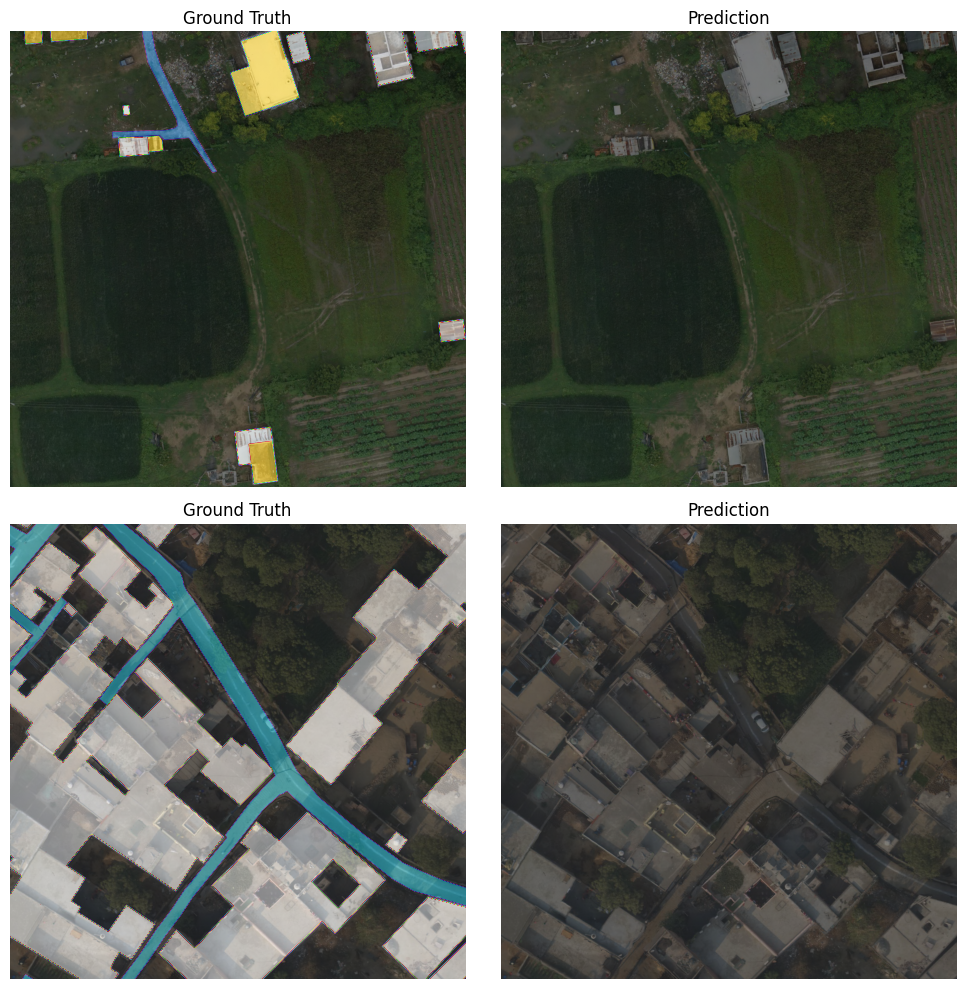

In [26]:
show_inference_samples(model, test_dataloader, preprocessor, n=2)

In [29]:
from transformers import MaskFormerForInstanceSegmentation
model = MaskFormerForInstanceSegmentation.from_pretrained("/kaggle/working/checkpoint_1")

Backbone maskformer-swin is not a supported model and may not be compatible with MaskFormer. Supported model types: resnet,swin


In [ ]:
train_model(
    model,
    train_dataloader,
    val_dataloader,
    preprocessor,
    metric,
    id2label,
    num_epochs=1,
    log_interval=1,
)

Current epoch: 1/1


  0%|          | 0/38 [00:00<?, ?it/s]

Iteration 1 - loss: 1.164854645729065
Iteration 2 - loss: 1.018158217271169
Iteration 3 - loss: 1.0899598449468613
Iteration 4 - loss: 1.2260872721672058
Iteration 5 - loss: 1.1464103162288666
Iteration 6 - loss: 1.1755638037409102
Iteration 7 - loss: 1.1590906009078026
Iteration 8 - loss: 1.2104858756065369


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f50de83be50>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Iteration 9 - loss: 1.093745417892933
Iteration 10 - loss: 0.9988804354586385
Iteration 11 - loss: 1.0031389050806563
Iteration 12 - loss: 0.9300285609295735
Iteration 13 - loss: 0.9354382867791823
Iteration 14 - loss: 0.8767534516751766
Iteration 15 - loss: 0.8965030855033547


In [27]:
save_directory = "checkpoint_1"

model.save_pretrained(save_directory)

preprocessor.save_pretrained(save_directory)

['checkpoint_1/preprocessor_config.json']

In [28]:
!zip -r "/kaggle/working/checkpoint_1.zip" "/kaggle/working/checkpoint_1"

  adding: kaggle/working/checkpoint_1/ (stored 0%)
  adding: kaggle/working/checkpoint_1/model.safetensors (deflated 8%)
  adding: kaggle/working/checkpoint_1/config.json (deflated 61%)
  adding: kaggle/working/checkpoint_1/preprocessor_config.json (deflated 47%)
